In [1]:
import scanpy as sc
import numpy as np
import scipy as sp
import pandas as pd
import json
import os
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib import colors
import seaborn as sb
import rpy2.rinterface_lib.callbacks
import logging
from pandas import DataFrame
from rpy2.robjects import pandas2ri
import anndata2ri

In [2]:
# Ignore R warning messages
#Note: this can be commented out to get more verbose R output
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

# Automatically convert rpy2 outputs to pandas dataframes
pandas2ri.activate()
anndata2ri.activate()
%load_ext rpy2.ipython

plt.rcParams['figure.figsize']=(8,8) #rescale figures
sc.settings.verbosity = 3
#sc.set_figure_params(dpi=200, dpi_save=300)
sc.logging.print_versions()

scanpy==1.5.1 anndata==0.7.3 umap==0.4.4 numpy==1.16.1 scipy==1.4.1 pandas==1.0.1 scikit-learn==0.22.1 statsmodels==0.11.0 python-igraph==0.8.2 louvain==0.7.0 leidenalg==0.8.0


In [3]:
%%R
# Load libraries from correct lib Paths for my environment - ignore this!
.libPaths(.libPaths()[c(3,2,1)])

# Load all the R libraries we will be using in the notebook
library(scran)

In [4]:
def csv_to_perturb_data(path = os.getcwd(), name = "/cbc_gbc_dict.csv"):
    """ Turn the original cbc_gbc_dict csv to a simpler one for downstream analysis
    Especially the format provided in GSE90063_RAW

    Parameters
    ----------
    path : the path of your file, default is None
    name : the name of your file, default is "cbc_gbc_dict.csv"

    Returns
    -------
    a dataframe with two columns (sgRNA & gene)
    a list with all the sgRNAs
    """

    perturb = pd.read_csv(path + name, header=None)

    # delete the number
    perturb["rna"] = perturb[0].map(lambda x: x.split("_")[1])

    # a function to deal with one line in the original file
    def makepandas(i):
        y = perturb[1][i].split(",")
        t = [[perturb["rna"][i]] * len(y), y]
        return DataFrame(t).transpose()

    perturb_process = makepandas(0)

    for i in range(len(perturb)):
        perturb_process = perturb_process.append(makepandas(i), ignore_index=True)

    perturb_process.columns = ['sgRNA', 'cell']

    perturb = perturb_process.sort_values(by=['cell', 'sgRNA'], ignore_index=True)
    perturb['cell'] = perturb['cell'].str.strip()
    sgRNA_list = perturb['sgRNA'].drop_duplicates().tolist()

    return perturb, sgRNA_list


def json_to_perturb_data(path = os.getcwd(), name = "/cells_per_protospacer.json"):
    """ Turn the original cells_per_protospacer.json to a simpler one for downstream analysis
    Especially the format provided in our dataset

    Parameters
    ----------
    path : the path of your file, default is None
    name : the name of your file, default is "cbc_gbc_dict.csv"

    Returns
    -------
    a dataframe with two columns (sgRNA & gene)
    a list with all the sgRNAs
    """
    with open(path + name) as f:
        data = json.load(f)

        mock = list(data.keys())

    def create_one_from_dic(i):
        df = pd.DataFrame(data[mock[i]], columns=['cell'])
        df["sgRNA"] = "-".join(mock[i].split('-')[:-1])
        return df

    perturb_process = create_one_from_dic(0)

    for i in range(1, len(mock)):
        perturb_process = perturb_process.append(create_one_from_dic(i), ignore_index=True)

    perturb_process = perturb_process.sort_values(by=['sgRNA', 'cell'], ignore_index=True)
    perturb_process['cell'] = perturb_process['cell'].str.strip()
    sgRNA_list = perturb_process['sgRNA'].drop_duplicates().tolist()

    return perturb_process, sgRNA_list


def anndata_sgRNA(anndata, perturb, sgRNA_list = []):
    """ Annotate the sgRNA info to anndata

    Parameters
    ----------
    anndata : anndata
    perturb : the perturb info get from perturb_process
    sgRNA_list : sgRNA_list info get from perturb_process or perturb, it's okay to be none

    Return
    -------
    anndata with perturb info of each sgRNA

    """
    if sgRNA_list == []:
        sgRNA_list = perturb['sgRNA'].drop_duplicates().tolist()

    sgRNA_info = pd.DataFrame(0, index=anndata.obs.index.tolist(), columns=sgRNA_list)
    for i in range(len(perturb)):
        sgRNA_info[perturb["sgRNA"][i]][perturb["cell"][i]] += 1
    anndata.obs = pd.concat([anndata.obs, sgRNA_info.reindex(anndata.obs.index)], axis=1)

    return anndata


def hist_figure(anndata, sgRNA_list, title, type=""):
    """

    Parameters
    ----------
    anndata: anndata
    sgRNA_list: sgRNA_list of perturbations
    title: the title of the plot
    type:
     type = "perturbed" plot 'Detected perturbed times/cell'
     type = "sgRNA" plot 'Detected sgRNA/cell'
     type = "" plot both

     Return
    -------
    hist graph
    """
    def draw(t, xlabel, title):
        fig, ax = plt.subplots()
        ax.hist(t, range(t.value_counts().index[-1] + 1), density=False)

        for rect in ax.patches:
            height = rect.get_height()
            ax.annotate(f'{int(height)}', xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 5), textcoords='offset points', ha='center', va='bottom')

        plt.xlabel(xlabel)
        plt.ylabel('Cell number')
        plt.title(title)
        plt.show()

    if type == "" or type == "perturbed":
        t = anndata.obs.iloc[:, 0:len(sgRNA_list)].sum(axis=1)
        draw(t, 'Detected perturbed times/cell', title)

    if type == "" or type == "sgRNA":
        t = (anndata.obs.iloc[:, 0:len(sgRNA_list)] != 0).sum(axis=1)
        draw(t, 'Detected sgRNA/cell', title)



In [5]:
train_path = "/Users/guojuanru/Desktop/Yale/newdata/fcb.ycga.yale.edu:3010/LxlobimuVf2jxVD6xPK4t7UFT98aR/100820/MOCK_MON_crispr_combine"
test_path = "/Users/guojuanru/Desktop/Yale/newdata/fcb.ycga.yale.edu:3010/LxlobimuVf2jxVD6xPK4t7UFT98aR/100820/SARS2_MON_crispr_combine"

mock = sc.read_10x_mtx(train_path + "/filtered_feature_bc_matrix")
sars = sc.read_10x_mtx(test_path + "/filtered_feature_bc_matrix")

perturb_mock, sgRNA_list_mock = json_to_perturb_data(path = train_path + "/crispr_analysis")
perturb_sars, sgRNA_list_sars = json_to_perturb_data(path = test_path + "/crispr_analysis")

mock = anndata_sgRNA(mock, perturb_mock, sgRNA_list_mock)
sars = anndata_sgRNA(sars, perturb_sars, sgRNA_list_sars)


--> This might be very slow. Consider passing `cache=True`, which enables much faster reading from a cache file.
--> This might be very slow. Consider passing `cache=True`, which enables much faster reading from a cache file.


In [24]:
adata = mock.concatenate(sars)

... storing 'feature_types' as categorical


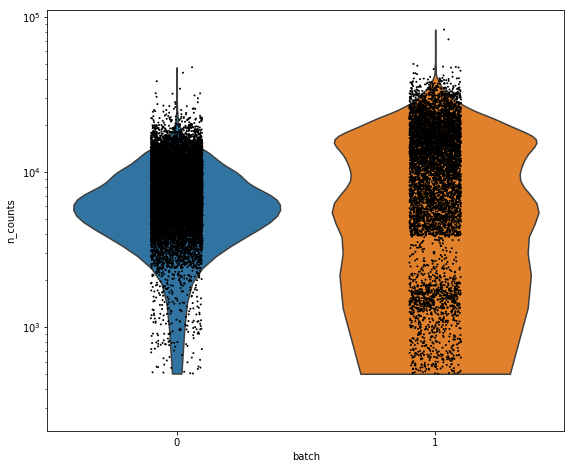

In [25]:
# Quality control - calculate QC covariates
adata.obs['n_counts'] = adata.X.sum(1)
adata.obs['log_counts'] = np.log(adata.obs['n_counts'])
adata.obs['n_genes'] = (adata.X > 0).sum(1)

# Quality control - plot QC metrics
#Sample quality plots
t1 = sc.pl.violin(adata, 'n_counts', groupby='batch', size=2, log=True, cut=0)

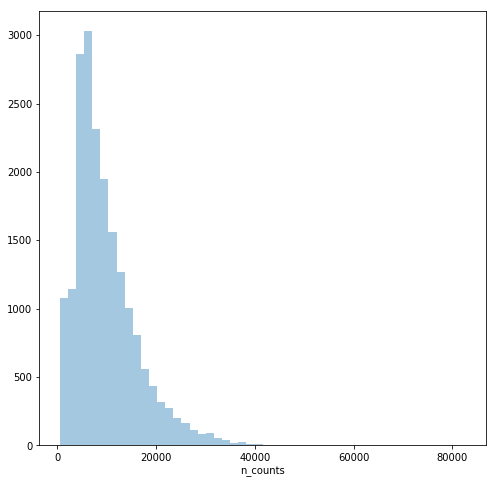

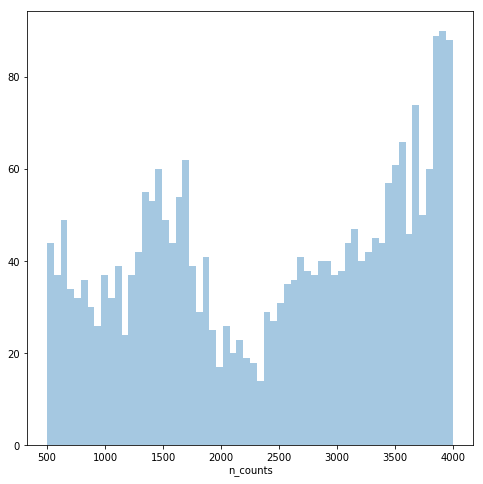

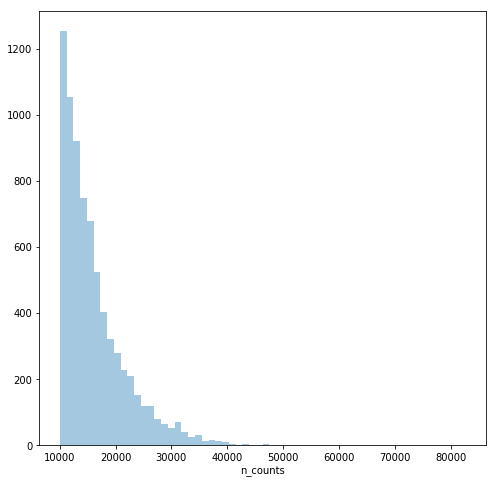

In [26]:
#Thresholding decision: counts
p3 = sb.distplot(adata.obs['n_counts'], kde=False)
plt.show()

p4 = sb.distplot(adata.obs['n_counts'][adata.obs['n_counts']<4000], kde=False, bins=60)
plt.show()

p5 = sb.distplot(adata.obs['n_counts'][adata.obs['n_counts']>10000], kde=False, bins=60)
plt.show()

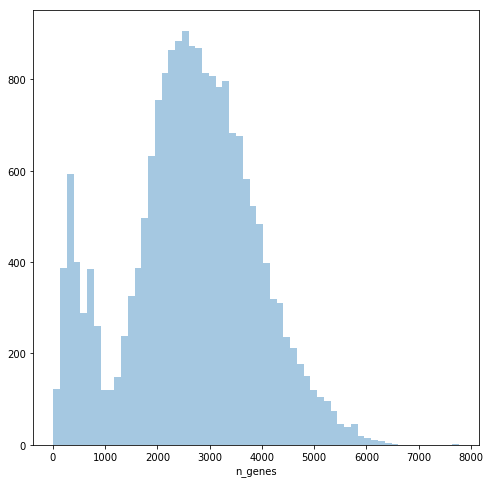

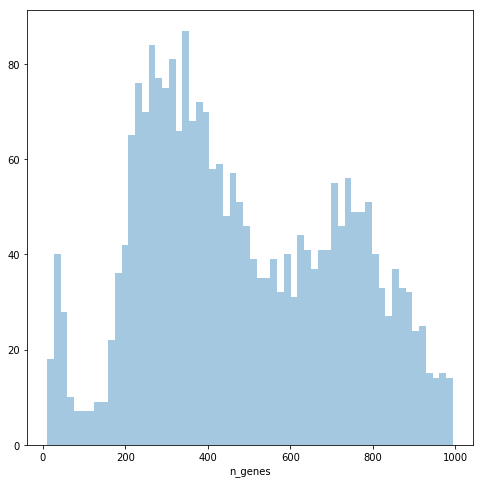

In [27]:
#Thresholding decision: genes
p6 = sb.distplot(adata.obs['n_genes'], kde=False, bins=60)
plt.show()

p7 = sb.distplot(adata.obs['n_genes'][adata.obs['n_genes']<1000], kde=False, bins=60)
plt.show()

In [28]:
# Filter cells according to identified QC thresholds:
print('Total number of cells: {:d}'.format(adata.n_obs))

sc.pp.filter_cells(adata, min_counts = 2400)
print('Number of cells after min count filter: {:d}'.format(adata.n_obs))

sc.pp.filter_cells(adata, max_counts = 40000)
print('Number of cells after max count filter: {:d}'.format(adata.n_obs))

sc.pp.filter_cells(adata, min_genes = 1000)
print('Number of cells after gene filter: {:d}'.format(adata.n_obs))

Total number of cells: 19409
filtered out 1157 cells that have less than 2400 counts
Number of cells after min count filter: 18252
filtered out 24 cells that have more than 40000 counts
Number of cells after max count filter: 18228
filtered out 1540 cells that have less than 1000 genes expressed
Number of cells after gene filter: 16688


In [29]:
#Filter genes:
print('Total number of genes: {:d}'.format(adata.n_vars))

# Min 20 cells - filters out 0 count genes
sc.pp.filter_genes(adata, min_cells=20)
print('Number of genes after cell filter: {:d}'.format(adata.n_vars))

Total number of genes: 29616
filtered out 14283 genes that are detected in less than 20 cells
Number of genes after cell filter: 15333


In [30]:
#Perform a clustering for scran normalization in clusters
adata_pp = adata.copy()
sc.pp.normalize_per_cell(adata_pp, counts_per_cell_after=1e6)
sc.pp.log1p(adata_pp)
sc.pp.pca(adata_pp, n_comps=15)
sc.pp.neighbors(adata_pp)
sc.tl.louvain(adata_pp, key_added='groups', resolution=0.5)

#Preprocess variables for scran normalization
input_groups = adata_pp.obs['groups']
data_mat = adata.X.T

normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
computing PCA
    with n_comps=15
    finished (0:00:07)
computing neighbors
    using 'X_pca' with n_pcs = 15
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:03)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 8 clusters and added
    'groups', the cluster labels (adata.obs, categorical) (0:00:04)


In [31]:
%%R
# Load libraries from correct lib Paths for my environment - ignore this!
.libPaths(.libPaths()[c(3,2,1)])

# Load all the R libraries we will be using in the notebook
library(scran)

In [32]:
%%R -i data_mat -i input_groups -o size_factors
size_factors = computeSumFactors(data_mat, clusters=input_groups, min.mean=0.1)

In [33]:
#Delete adata_pp
del adata_pp

# Visualize the estimated size factors
adata.obs['size_factors'] = size_factors

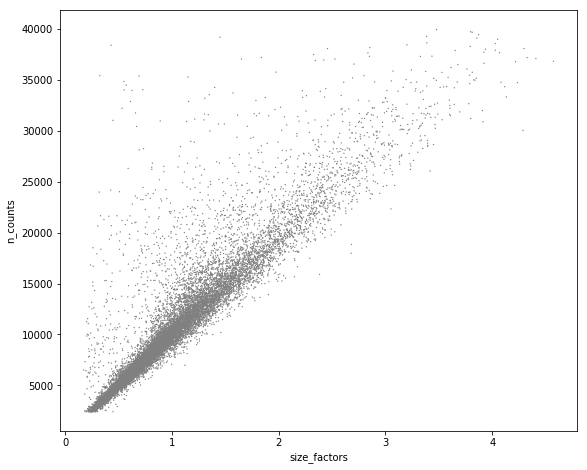

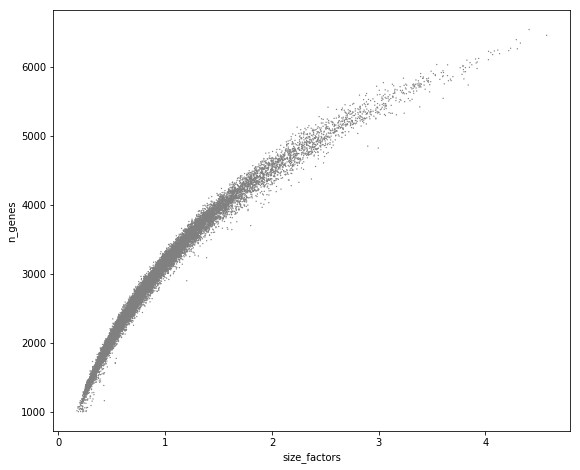

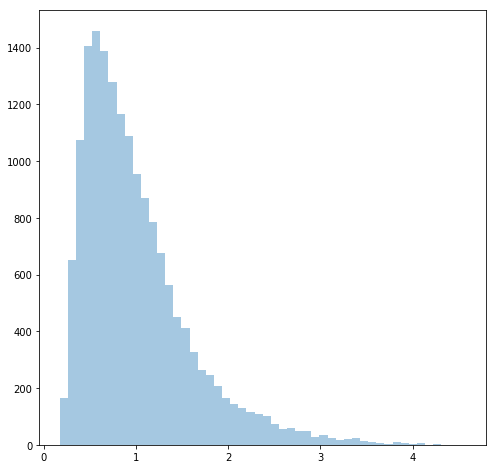

In [34]:
# Visualize the estimated size factors
adata.obs['size_factors'] = size_factors

sc.pl.scatter(adata, 'size_factors', 'n_counts')
sc.pl.scatter(adata, 'size_factors', 'n_genes')

sb.distplot(size_factors, bins=50, kde=False)
plt.show()

In [35]:
#Keep the count data in a counts layer
adata.layers["counts"] = adata.X.copy()

In [36]:
#Normalize adata 
adata.X /= adata.obs['size_factors'].values[:,None]
sc.pp.log1p(adata)

In [37]:
# Store the full data set in 'raw' as log-normalised data for statistical testing
adata.raw = adata

In [38]:
# ComBat batch correction
sc.pp.combat(adata, key='batch')

Standardizing Data across genes.

Found 2 batches

Found 0 numerical variables:
	

Fitting L/S model and finding priors

Finding parametric adjustments

Adjusting data



In [39]:
sc.pp.highly_variable_genes(adata, flavor='cell_ranger', n_top_genes=4000)
print('\n','Number of highly variable genes: {:d}'.format(np.sum(adata.var['highly_variable'])))

extracting highly variable genes
    finished (0:00:03)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)

 Number of highly variable genes: 4000


In [40]:
# Calculate the visualizations
sc.pp.pca(adata, n_comps=100, use_highly_variable= True, svd_solver='arpack')

computing PCA
    on highly variable genes
    with n_comps=100
    finished (0:00:26)


In [42]:
adata.write('/Users/guojuanru/Desktop/Yale/code/total_after.h5ad')

In [47]:
adata = sc.read_h5ad('/Users/guojuanru/Desktop/Yale/code/total_after.h5ad')
adata

AnnData object with n_obs × n_vars = 16688 × 15333
    obs: 'ACE2', 'ACVR1B', 'ADAM17', 'ANPEP', 'ARID1A', 'ATRX', 'CABIN1', 'CTSL', 'DOLK', 'DPF2', 'DPP4', 'DYRK1A', 'JMJD6', 'KDM6A', 'LOC103223006', 'Non-Targeting', 'PCBD1', 'PHF6', 'PHIP', 'PIAS1', 'PIAS2', 'RAD54L2', 'SH3YL1', 'SIAH1', 'SMAD3', 'SMAD4', 'SMARCA4', 'SMARCA5', 'SMARCE1', 'TMPRSS2', 'TMPRSS4', 'TMX3', 'UBXN7', 'batch', 'n_counts', 'log_counts', 'n_genes', 'size_factors'
    var: 'gene_ids', 'feature_types', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'batch_colors', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'
    layers: 'counts'